In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d jtiptj/chest-xray-pneumoniacovid19tuberculosis

100% 1.73G/1.74G [00:19<00:00, 118MB/s]
100% 1.74G/1.74G [00:19<00:00, 96.0MB/s]


In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [4]:
import zipfile
import os

# Replace 'your_dataset_directory.zip' with the actual zip file name
zip_file_path = '/content/chest-xray-pneumoniacovid19tuberculosis.zip'
extracted_folder_path = '/content/dataset/'

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

In [5]:
your_dataset_directory = '/content/dataset'

# Use ImageDataGenerator to augment and normalize the data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Use flow_from_directory to load the data directly from folders
train_generator = train_datagen.flow_from_directory(
    directory=your_dataset_directory + '/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',  # Change class_mode to 'categorical'
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    directory=your_dataset_directory + '/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    directory=your_dataset_directory + '/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 6326 images belonging to 4 classes.
Found 38 images belonging to 4 classes.
Found 771 images belonging to 4 classes.


In [6]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

87910968/87910968 [==============================] - 1s 0us/step


In [7]:
num_classes = len(train_generator.class_indices)
batch_size = 32
epochs = 20
learning_rate = 0.01

In [8]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [9]:
# Add custom layers on top of the base InceptionV3 model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Unfreeze some layers of the base InceptionV3 model for fine-tuning
for layer in model.layers[:100]:
    layer.trainable = True

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary to review the architecture
model.summary()

# Set up callbacks (optional but recommended)
checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True)
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0][0

In [10]:
# Train the model
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/20
198/198 [==============================] - ETA: 0s - loss: 0.6228 - accuracy: 0.7555

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


198/198 [==============================] - 220s 790ms/step - loss: 0.6228 - accuracy: 0.7555 - val_loss: 1.0670 - val_accuracy: 0.5526
Epoch 2/20
198/198 [==============================] - 158s 796ms/step - loss: 0.2198 - accuracy: 0.9289 - val_loss: 0.5353 - val_accuracy: 0.7895
Epoch 3/20
198/198 [==============================] - 158s 800ms/step - loss: 0.1451 - accuracy: 0.9497 - val_loss: 0.2806 - val_accuracy: 0.8421
Epoch 4/20
198/198 [==============================] - 160s 808ms/step - loss: 0.1199 - accuracy: 0.9600 - val_loss: 0.2320 - val_accuracy: 0.9211
Epoch 5/20
198/198 [==============================] - 158s 799ms/step - loss: 0.0946 - accuracy: 0.9696 - val_loss: 0.2093 - val_accuracy: 0.9211
Epoch 6/20
198/198 [==============================] - 153s 771ms/step - loss: 0.0850 - accuracy: 0.9720 - val_loss: 0.2098 - val_accuracy: 0.9211
Epoch 7/20
198/198 [==============================] - 158s 795ms/step - loss: 0.0845 - accuracy: 0.9681 - val_loss: 0.1517 - val_accura

In [11]:
# Save the trained model as an h5 file
model.save('/content/fine_tuned_inceptionv3.h5')

In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

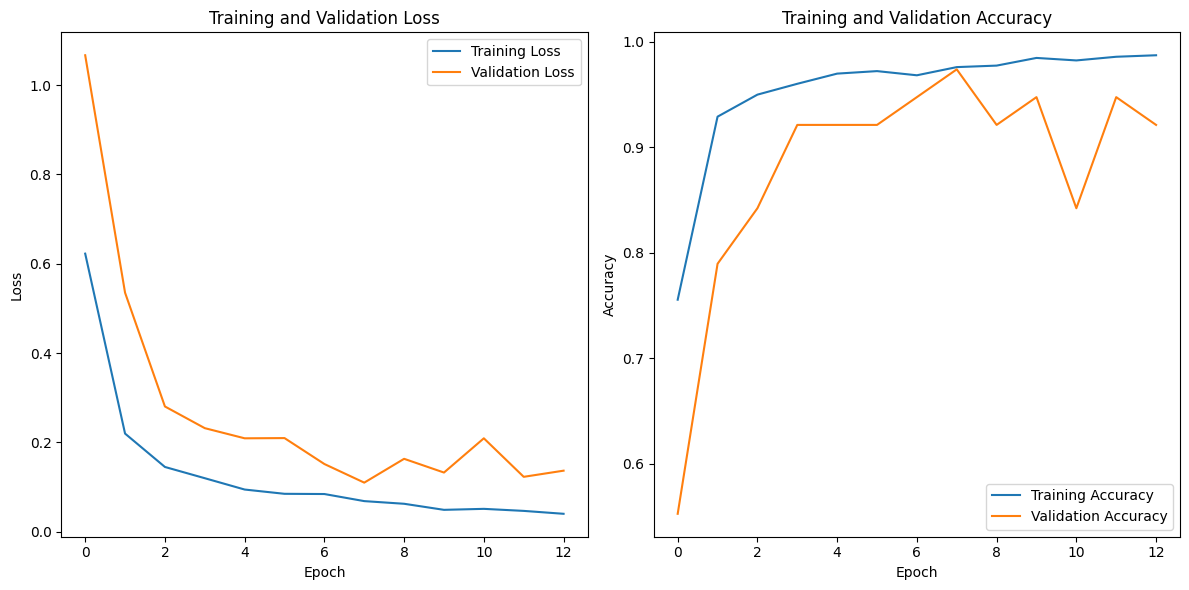

In [13]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

In [14]:
test_loss, test_accuracy = model.evaluate(test_generator, batch_size=32)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy * 100)

25/25 [==============================] - 11s 359ms/step - loss: 0.2730 - accuracy: 0.9170
Test Loss: 0.2730332612991333
Test Accuracy: 91.69909358024597


25/25 [==============================] - 11s 342ms/step


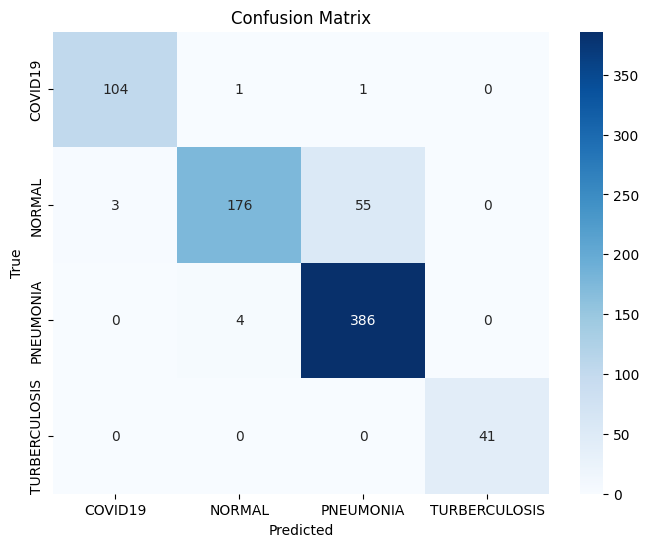


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       106
           1       0.97      0.75      0.85       234
           2       0.87      0.99      0.93       390
           3       1.00      1.00      1.00        41

    accuracy                           0.92       771
   macro avg       0.95      0.93      0.94       771
weighted avg       0.92      0.92      0.91       771



In [15]:
# Generate predictions on the test set
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert true labels to one-hot encoding
y_true_onehot = test_generator.classes

# Create confusion matrix
conf_matrix = confusion_matrix(y_true_onehot, y_pred_classes)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true_onehot, y_pred_classes))